In [1]:
import requests
from bs4 import BeautifulSoup
import gpxpy
import matplotlib.pyplot as plt
import numpy as np
import gpxpy.gpx 


In [2]:
url = 'https://www.la-flamme-rouge.eu/maps/races/calendar?month=10&year=2020'
headers={'User-Agent':'Mozilla/5'}
r = requests.get(url, allow_redirects=True,headers=headers)
soup = BeautifulSoup(r.text,'html.parser')
test = soup.find_all('div', {'class': 'day__body'})
tracks = [t.find_all('a', href=True) for t in test]
all_tracks = [subtrack['href'].split('/')[3].split('?')[0] for track in tracks for subtrack in track ]
tracks_final = [track for track in all_tracks if track != 'view']

In [3]:
print(tracks_final)

['383863', '375303', '383865', '322123', '383868', '322158', '386340', '383870', '383657', '383655', '386318', '383881', '382288', '375307', '369657', '383882', '382289', '382292', '382290', '383656', '385698', '385814', '322127', '369658', '383883', '383381', '383658', '385699', '384603', '306423', '383885', '306426', '328728', '306413', '384661', '384671', '328729', '369674', '328730', '386026', '369715', '328731', '386029', '306417', '328732', '387641', '386030', '384875', '369676', '386263', '328733', '385209', '386031', '388375', '388336', '306419', '306421', '322287', '328453', '306264', '328454', '306260', '328455', '306259', '390685', '385520', '306258', '385770', '390902', '390903', '306257', '318469', '327298', '318703', '306185', '318473', '306186', '318475', '391237', '391235', '306255', '318477', '391238', '391236', '392635', '392177', '318481', '393027', '306253', '392363', '393424', '393803', '318501', '394253', '318508', '394553', '318514', '394871', '318523', '395245',

In [5]:
def get_gpx_track(track_number=[]):
    """Send request to la flamme rouge website to a specific gpx track
    
    Parameters
    ------------
    track_number: list of track numbers to parse (int)
        
    Returns
    ------------
    The parsed URLs as a list
    """
    soup = []
    for track in track_number:
        url = 'http://la-flamme-rouge.eu/maps/viewtrack/gpx/'+str(track)
        headers={'User-Agent':'Mozilla/5'}
        r = requests.get(url, allow_redirects=True,headers=headers)
        soup.append(BeautifulSoup(r.text,'html.parser'))
    return soup

def get_elevation(track_html):
    """Extract stage name and elevation information from the text of the parsed URLs
    
    Parameters
    ------------
    track_html: list of parsed URLs
    
    Returns
    ------------
    A dictionary where the key is the stage name and the value is a list [positive_elevation_gain, max_elevation]
    """
    # get elevation from html
    elev_stage = {}
    for track in track_html:
        elev = [int(elev.text) for elev in track.find_all('ele')]
        name = track.find('name').text
        elev_change = sum([elev[i+1]-elev[i] for i in range(len(elev)-1) if elev[i+1]>elev[i]])
        max_elev = max(elev)
        elev_stage[name] = [elev_change, max_elev]
    return elev_stage

In [6]:
%%timeit
track_html = get_gpx_track(track_number=[34572,386318,375307])

9.4 s ± 1.42 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
elev_change= get_elevation(track_html)

NameError: name 'track_html' is not defined

In [ ]:
print(elev_change)

In [7]:
def get_gpx_file(track_number=[]):
    """Send request to la flamme rouge website to a specific gpx track
    saves the gpx file into "/gpx/__track_number__.gpx
    Parameters
    ------------
    track_number: list of track numbers to parse (int)
        
    Returns
    ------------
    void
    """
    for track in track_number:
        url = 'http://la-flamme-rouge.eu/maps/viewtrack/gpx/'+str(track)
        headers={'User-Agent':'Mozilla/5'}
        r = requests.get(url, allow_redirects=True,headers=headers)
        open('gpx/'+str(track)+'.gpx', 'wb').write(r.content)


def get_data_from_gpx(track_number=[]):
    """Extract stage name elevation, max elevation and distance from the text of the files
    
    Parameters
    ------------
    track_number: number of gpx file
    
    Returns
    ------------
    A dictionary where the key is the stage name and the value is a list [positive_elevation_gain, max_elevation, distance]
    """
    data_race={}
    for track in track_number:
        file_name = 'gpx/'+str(track)+'.gpx'
        gpx_file= open(file_name, 'r')
        gpx = gpxpy.parse(gpx_file)
        name = gpx.tracks[0].name
        elev = [point.elevation for point in gpx.tracks[0].segments[0].points]
        elev_change = sum([ elev[i+1] - elev[i] for i in range(len(elev)-1) if elev[i+1] > elev[i] ])
        max_elev = max(elev)
        distance = round(gpx.length_2d()/1000,2)
        data_race[name] = [elev_change, max_elev, distance]

    return [data_race,elev]

In [8]:
get_gpx_file(track_number=[306106])

In [9]:
data=get_data_from_gpx(track_number=[306106])
print(data[0])

{'Tour de France 2020 - Stage 13': [4459.0, 1583.0, 192.11]}


In [20]:
#some functions for the software: get_altitude, get_distance, is_uphill_finish
#is_over_2000 is_over_1800 is_over_1500

def is_over_1500(tracknumber)->bool:
    """
    determines whether the race got over 1500m of altitude
    """
    data = get_data_from_gpx(track_number=[tracknumber])
    if list(data[0].values())[0][1] >= 1500:
        return True
    return False

def is_over_1800(tracknumber)->bool:
    """
    determines whether the race got over 1800m of altitude
    """
    data = get_data_from_gpx(track_number=[tracknumber])
    if list(data[0].values())[0][1] >= 1800:
        return True
    return False

def is_over_2000(tracknumber)->bool:
    """
    determines whether the race got over 2000m of altitude
    """
    data = get_data_from_gpx(track_number=[tracknumber])
    if list(data[0].values())[0][1] >= 2000:
        return True
    return False

def get_distance(tracknumber)->float:
    """
    Returns the total distance in km

    Input
    ------------------------- 
    tracknumber (int)

    Output
    -------------------------
    distance (float)
    """
    data = get_data_from_gpx(track_number=[tracknumber])
    return list(data[0].values())[0][2]

def get_altitude(tracknumber, distance=0)->float:
    """
    Returns the altitude of a waypoint, given file name and distance at which you wan to get the altitude
    
    Input
    ------------------------- 
    tracknumber (int) and distance (float, km)

    Output
    -------------------------
    altitude (float, m)
    """
    data = get_data_from_gpx(track_number=[tracknumber])
    waypoint = int( distance * len(data[1]) / list(data[0].values())[0][2])
    return data[1][waypoint-1]

def is_uphill_finish(tracknumber)->bool:
    """
    Determines whether a gpx track can be classified as (uphill finish) UF or not.
    In order to be a UF the criteria that must be met is the following (can be modified)
    -in the last 1.5 km of the race there has to be an average gradient of at least 5%
    -that means at least 75m of elevation

    Input
    ------------------------- 
    tracknumber (int) 

    Output
    -------------------------
    Bool
    """
    finish = get_distance(tracknumber)

    if get_altitude(tracknumber, finish) - get_altitude(tracknumber, finish -1.5) >=75:
        return True
    else:
        return False


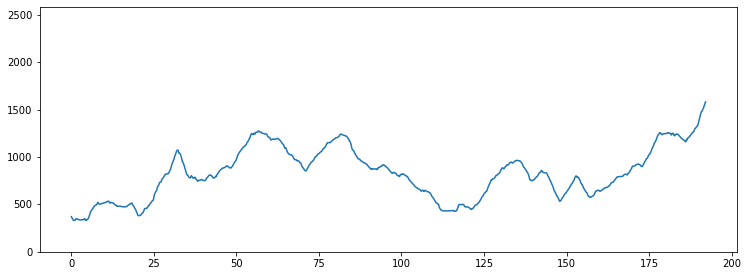

In [21]:
plt.figure(figsize=(12.5, 4.5))
dist = get_distance(306106)
dist_graph =[]
for i in range(len(data[1])):
    dist_graph.append( i/len(data[1]) * dist)
plt.plot(dist_graph, data[1])
plt.ylim(0,max(data[1])+1000)
plt.show()


In [22]:
is_uphill_finish(306106)
is_over_2000(306106)

False

In [42]:
#quantile tests
def quantile(tracknumber, percentage=0.5)->float:
    """
    takes as input the tracknumber and a percentage (between 0 and 1) and returns the amount of kms
    necessary to reach that percentage of covered elevation. Example: quantile(306106, 0.5) takes the infos
    from track number 306106 and returns the amount of km necessary to cover half of the total positive
    elevation.

    Input
    -------------------------
    tracknumber (int)
    percentage (float)

    Output
    -------------------------
    distance (float, km)
    """
    if (percentage <0 or percentage >1):
        print('Error usage: percentage must be between 0-1')
        return -1
    if (percentage == 0):
        return 0
    data=get_data_from_gpx(track_number=[306106])
    elev = data[1]
    elev_change = list(data[0].values())[0][0]
    max_elev = list(data[0].values())[0][1]
    distance = list(data[0].values())[0][2]
    temp = 0
    for i in range(len(elev)-1):
        if elev[i+1] > elev[i]:
            temp += elev[i+1] - elev[i]
            if(temp >= elev_change * percentage):
                return round(dist/len(elev) * i,2)



    


In [6]:
gpx_file = open('gpx/34572.gpx', 'r') 

gpx = gpxpy.parse(gpx_file) 
 

In [21]:
print(gpx.tracks[0].segments[0].points[-1].latitude)

44.40537


In [51]:
import Analyzer
obj = Analyzer.Analyzer('34572')

In [53]:

url = 'http://la-flamme-rouge.eu/maps/viewtrack/gpx/417959'
headers = {'User-Agent':'Mozilla/5'}
r = requests.get(url, allow_redirects=True,headers=headers)
soup = BeautifulSoup(r.text,'html.parser')

lat = []
lon = []
ele = []
for i in soup.find('trkseg').find_all('trkpt'):
    lat.append(i['lat'])
    lon.append(i['lon'])
    ele.append(i.find('ele').text)
race_name = soup.find('name').text
elev_change = 0     ## sets elev_change = 0
distance = 0
max_elev = int(ele[0])
last_point = [float(lat[-1]), float(lon[-1])]

for i in range(1,len(ele)):                                 ## loops through all elements 
                        ## evaluate total elevation change
    if(int(ele[i])>int(ele[i-1])):                          ## if this point is higher than previous 
        elev_change += int(ele[i])-int(ele[i-1])            ## add the difference to elev_change
                        ## search for highest point in the race
    if(int(ele[i]) > int(max_elev)):                             ## if this point is higher than max_elev
        max_elev=ele[i]                                     ## set max_elev to new value
                        ## haversine distance
    begin = (float(lat[i]), float(lon[i]))
    end = (float(lat[i-1]), float(lon[i-1]))
    distance += haversine( end, begin )
                        ## append last point (for weather data)


print(race_name)
print(elev_change)
print(max_elev)
print(round(distance,2))
print(last_point)

Itzulia 2021 Stage 2
2518
492
154.03
[43.31001, -3.00972]


In [74]:
from haversine import haversine, Unit

### race name and day of month

In [26]:
import re
# get race name and date from calendar
#def get_race_day(track_number=[]):
url = 'https://www.la-flamme-rouge.eu/maps/races/calendar?month=10&year=2020'
headers={'User-Agent':'Mozilla/5'}
r = requests.get(url, allow_redirects=True,headers=headers)
soup = BeautifulSoup(r.text,'html.parser')

In [41]:
day_of_race = soup.find_all('td', class_='day')[0].find('div', class_='day__header__day').text.strip()
race_name = soup.find_all('td', class_='day')[0].find('div', class_='race__name').text.replace('\n',' - ').strip()
race_name = " ".join(race_name.split())